In [3]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logPath = "training/"

with open("hyperParams.json") as f:
    instanceParams = json.load(f)

printFrequency = instanceParams["printFreq"]
batchSize = 1#instanceParams["batchSize"]

iterations = instanceParams["iterations"]
baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate
snapshotFrequency = instanceParams["snapshotFreq"]

photoAlpha = instanceParams["photoParams"]["robustness"]
photoBeta = instanceParams["photoParams"]["scale"]
wei = instanceParams["smoothParams"]["weight"]

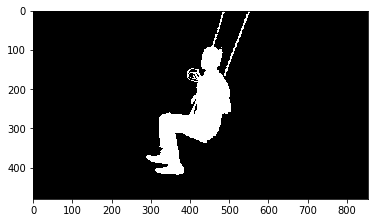

In [5]:
gt = np.zeros((480, 854))
gt = mpimg.imread("../example_data/data/DAVIS/Annotations/480p/swing/00043.png")
plt.imshow(gt, cmap='gray')

In [6]:
flow = np.zeros((480, 854, 2))

In [7]:
flow = np.expand_dims(flow, 0)
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

In [8]:
flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

In [9]:
img0 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/swing/00043.jpg"), channels=3, dtype=tf.uint8)
img1 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/swing/00044.jpg"), channels=3, dtype=tf.uint8)

rgb0 = tf.cast(img0, tf.float32) - [[[[0,0,0]]]]
rgb1 = tf.cast(img1, tf.float32) - [[[[0,0,0]]]]

In [10]:
lambdaTensor = tf.placeholder(tf.float32)
sLoss = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
pLoss = photoLoss(flow, rgb0, rgb1, photoAlpha, photoBeta)

tLoss = pLoss + lambdaTensor * sLoss

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
sGrad = tf.gradients(sLoss, flow)
pGrad = tf.gradients(pLoss, flow)
tGrad = tf.gradients(tLoss, flow)

In [12]:
momentum1 = 0.9
momentum2 = 0.999

def attach_SGD_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]
    
def attach_ADAM_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.AdamOptimizer(learning_rate=learningRate , beta1=momentum1, beta2=momentum2)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]

In [15]:
itr = 9000
solver, solver_op, learningRateTensor = attach_SGD_Solver(tLoss)

In [16]:
init = tf.global_variables_initializer()
sLosses = []
pLosses = []
sGrads = []
pGrads = []
tGrads = []
flows = []
start_time = None
print_freq = 10
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, itr + 2):
        feed_dict = {
            learningRateTensor: 5e-5,
            lambdaTensor: 1000
        }
        _, p, s, f, sg = sess.run([solver_op, pLoss, sLoss, flow, sGrad], feed_dict = feed_dict)
        if i % print_freq == 1:
            print(i)
            pLosses.append(np.mean(p))
            sLosses.append(np.mean(s))
            flows.append(deepcopy(f[0]))
            print "Photo loss: %f" % float(pLosses[-1])
            print "Smooth loss: %f" % float(sLosses[-1])

1
Photo loss: 4052.045654
Smooth loss: 0.000004
11
Photo loss: 2957.054443
Smooth loss: 0.225031
21
Photo loss: 2717.764160
Smooth loss: 0.280809
31
Photo loss: 2577.827393
Smooth loss: 0.311076
41
Photo loss: 2477.926270
Smooth loss: 0.330279
51
Photo loss: 2397.238037
Smooth loss: 0.348068
61
Photo loss: 2333.590576
Smooth loss: 0.361503
71
Photo loss: 2280.220703
Smooth loss: 0.373980
81
Photo loss: 2235.028809
Smooth loss: 0.382007
91
Photo loss: 2195.024414
Smooth loss: 0.391143
101
Photo loss: 2160.813477
Smooth loss: 0.396654
111
Photo loss: 2127.529785
Smooth loss: 0.402565
121
Photo loss: 2098.182617
Smooth loss: 0.408082
131
Photo loss: 2072.650391
Smooth loss: 0.413419
141
Photo loss: 2046.629517
Smooth loss: 0.417397
151
Photo loss: 2020.706909
Smooth loss: 0.421041
161
Photo loss: 1999.478027
Smooth loss: 0.424886
171
Photo loss: 1977.808472
Smooth loss: 0.429015
181
Photo loss: 1956.924072
Smooth loss: 0.430946
191
Photo loss: 1937.582886
Smooth loss: 0.433776
201
Photo l

1631
Photo loss: 1432.909790
Smooth loss: 0.473559
1641
Photo loss: 1431.161743
Smooth loss: 0.473430
1651
Photo loss: 1430.816895
Smooth loss: 0.473464
1661
Photo loss: 1429.747070
Smooth loss: 0.474518
1671
Photo loss: 1429.295654
Smooth loss: 0.474327
1681
Photo loss: 1427.495850
Smooth loss: 0.474369
1691
Photo loss: 1426.579956
Smooth loss: 0.473854
1701
Photo loss: 1426.619873
Smooth loss: 0.475006
1711
Photo loss: 1425.102051
Smooth loss: 0.474059
1721
Photo loss: 1424.921753
Smooth loss: 0.474523
1731
Photo loss: 1423.403442
Smooth loss: 0.474483
1741
Photo loss: 1423.385498
Smooth loss: 0.474133
1751
Photo loss: 1422.067749
Smooth loss: 0.474428
1761
Photo loss: 1421.710693
Smooth loss: 0.474420
1771
Photo loss: 1420.422852
Smooth loss: 0.474937
1781
Photo loss: 1419.576172
Smooth loss: 0.474948
1791
Photo loss: 1418.400879
Smooth loss: 0.474879
1801
Photo loss: 1417.796997
Smooth loss: 0.475009
1811
Photo loss: 1417.416382
Smooth loss: 0.474681
1821
Photo loss: 1417.479492
Sm

3271
Photo loss: 1363.394165
Smooth loss: 0.479310
3281
Photo loss: 1362.094116
Smooth loss: 0.479023
3291
Photo loss: 1362.308838
Smooth loss: 0.479054
3301
Photo loss: 1361.926636
Smooth loss: 0.479206
3311
Photo loss: 1361.089478
Smooth loss: 0.478639
3321
Photo loss: 1361.145020
Smooth loss: 0.478564
3331
Photo loss: 1361.341309
Smooth loss: 0.479344
3341
Photo loss: 1360.821411
Smooth loss: 0.478878
3351
Photo loss: 1359.969116
Smooth loss: 0.478938
3361
Photo loss: 1360.732544
Smooth loss: 0.478529
3371
Photo loss: 1361.432739
Smooth loss: 0.478732
3381
Photo loss: 1360.282715
Smooth loss: 0.479033
3391
Photo loss: 1360.194580
Smooth loss: 0.478971
3401
Photo loss: 1359.906128
Smooth loss: 0.478761
3411
Photo loss: 1359.945801
Smooth loss: 0.479316
3421
Photo loss: 1359.891968
Smooth loss: 0.478905
3431
Photo loss: 1359.660522
Smooth loss: 0.479577
3441
Photo loss: 1359.374512
Smooth loss: 0.478885
3451
Photo loss: 1359.230103
Smooth loss: 0.478852
3461
Photo loss: 1359.042358
Sm

4911
Photo loss: 1335.824463
Smooth loss: 0.480166
4921
Photo loss: 1335.625122
Smooth loss: 0.479851
4931
Photo loss: 1335.663818
Smooth loss: 0.479698
4941
Photo loss: 1335.996826
Smooth loss: 0.480451
4951
Photo loss: 1336.367188
Smooth loss: 0.481072
4961
Photo loss: 1336.156128
Smooth loss: 0.480819
4971
Photo loss: 1336.512451
Smooth loss: 0.481057
4981
Photo loss: 1335.811279
Smooth loss: 0.480912
4991
Photo loss: 1335.983398
Smooth loss: 0.480370
5001
Photo loss: 1335.451660
Smooth loss: 0.480311
5011
Photo loss: 1335.764404
Smooth loss: 0.480712
5021
Photo loss: 1336.438599
Smooth loss: 0.480751
5031
Photo loss: 1335.164673
Smooth loss: 0.480623
5041
Photo loss: 1334.623901
Smooth loss: 0.480707
5051
Photo loss: 1334.873535
Smooth loss: 0.480501
5061
Photo loss: 1335.377563
Smooth loss: 0.480685
5071
Photo loss: 1334.260132
Smooth loss: 0.480809
5081
Photo loss: 1334.388916
Smooth loss: 0.480528
5091
Photo loss: 1335.211426
Smooth loss: 0.481337
5101
Photo loss: 1334.189575
Sm

6551
Photo loss: 1325.651855
Smooth loss: 0.481657
6561
Photo loss: 1326.032349
Smooth loss: 0.481536
6571
Photo loss: 1326.196045
Smooth loss: 0.480789
6581
Photo loss: 1325.444336
Smooth loss: 0.480882
6591
Photo loss: 1325.741821
Smooth loss: 0.481192
6601
Photo loss: 1325.926758
Smooth loss: 0.481403
6611
Photo loss: 1325.148193
Smooth loss: 0.480893
6621
Photo loss: 1325.106689
Smooth loss: 0.480874
6631
Photo loss: 1326.534790
Smooth loss: 0.481576
6641
Photo loss: 1325.239624
Smooth loss: 0.481727
6651
Photo loss: 1325.572021
Smooth loss: 0.481469
6661
Photo loss: 1326.854004
Smooth loss: 0.480678
6671
Photo loss: 1326.157227
Smooth loss: 0.481056
6681
Photo loss: 1326.075684
Smooth loss: 0.481720
6691
Photo loss: 1325.547974
Smooth loss: 0.481457
6701
Photo loss: 1325.161255
Smooth loss: 0.481256
6711
Photo loss: 1325.448364
Smooth loss: 0.481524
6721
Photo loss: 1325.011963
Smooth loss: 0.481693
6731
Photo loss: 1325.913330
Smooth loss: 0.481189
6741
Photo loss: 1325.192383
Sm

8191
Photo loss: 1321.413330
Smooth loss: 0.480910
8201
Photo loss: 1321.671875
Smooth loss: 0.482121
8211
Photo loss: 1322.316162
Smooth loss: 0.480598
8221
Photo loss: 1321.252563
Smooth loss: 0.481168
8231
Photo loss: 1322.395630
Smooth loss: 0.481147
8241
Photo loss: 1321.436401
Smooth loss: 0.480628
8251
Photo loss: 1322.033081
Smooth loss: 0.481041
8261
Photo loss: 1322.258667
Smooth loss: 0.480801
8271
Photo loss: 1321.710693
Smooth loss: 0.480932
8281
Photo loss: 1321.526611
Smooth loss: 0.481118
8291
Photo loss: 1321.151489
Smooth loss: 0.481759
8301
Photo loss: 1321.875977
Smooth loss: 0.481332
8311
Photo loss: 1321.480103
Smooth loss: 0.480895
8321
Photo loss: 1321.798950
Smooth loss: 0.481012
8331
Photo loss: 1322.712402
Smooth loss: 0.481453
8341
Photo loss: 1321.845459
Smooth loss: 0.481453
8351
Photo loss: 1321.788086
Smooth loss: 0.481490
8361
Photo loss: 1320.804199
Smooth loss: 0.481217
8371
Photo loss: 1322.157959
Smooth loss: 0.481292
8381
Photo loss: 1322.035889
Sm

In [17]:
sLosses = np.array(sLosses)
pLosses = np.array(pLosses)
tLosses = pLosses + 1000 * sLosses

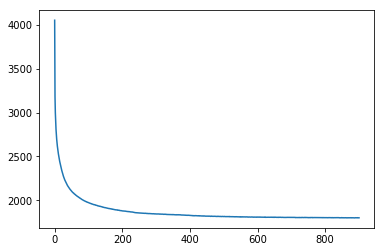

In [18]:
plt.plot(tLosses)

In [19]:
# np.save("swing_sgd_lambda10k", tLosses)
# np.save("swing_adam_lambda10k", tLosses)
np.save("swing_sgd_lambda1k", tLosses)
# np.save("swing_adam_lambda1k", tLosses)